# Réalisés par Adam HAMIDALLAH


TP 2 - Echantillonnage compressif
==================

In [ ]:
import numpy as np
import math
import scipy.fftpack as fft
import matplotlib.pyplot as plt

Récemment (début années 2004-présent), de nouveaux concepts et théorèmes ont été développés et risquent de 
révolutionner à relativement court terme la fabrication de certains appareils de mesure numériques (microphones, imageurs, analyseurs de spectres,...). 
Ces nouvelles techniques sont couramment appelées échantillonnage compressif, "compressive sampling" ou encore "compressed sensing". 

## 1. Le théorème de Shannon

Aujourd'hui, presque tous les appareils de mesure reposent sur le théorème de Shannon. Celui-ci (vous l'avez déjà vu en 2ème année) peut s'énoncer ainsi : 
> Soit $g:\mathbb{R}\to \mathbb{R}$ une fonction de $L^2(\mathbb{R})$. Si sa transformée de Fourier $\hat g$ a un support contenu dans l'intervalle $[-f_M, f_M]$, alors en l'échantillonnant à une fréquence d'échantillonnage $f_e\geq 2f_M$, on peut la reconstruire exactement.

Les instruments de mesures qui reposent sur ce théorème sont donc construits suivant le principe : 
>Filtre passe-bas $\rightarrow$ Echantillonnage à une fréquence $f>2f_M$ $\rightarrow$ Interpolation sinc

Pour beaucoup d'applications, ce principe présente deux défauts majeurs :
* Les signaux sont rarement naturellement à spectre borné, et on perd donc l'information haute-fréquence en effectuant un filtrage passe-bas.
* Pour beaucoup de signaux, il faut choisir une très haute fréquence d'échantillonnage pour obtenir un résultat satisfaisant. 
Ceci implique que les données à stocker ont une taille très importante et qu'il faut les compresser après coup (par exemple : jpeg).




## 2. L'échantillonnage compressif

**1. Principe général**

L'idée sous jacente à l'échantillonnage compressif est de réaliser la compression dès l'acquisition.
Supposons que le signal $x\in \mathbb{R}^n$ que l'on souhaite mesurer s'écrive comme une combinaison linéaire de la forme :
\begin{equation}
(1)~~~~~~~~~~~ x=\sum_{i=1}^m\alpha_i \psi_i
\end{equation}
où $\psi_i\in \mathbb{R}^n, \ i=1..m$, sont des "fonctions de base" (en traitement d'images, ces fonctions pourraient être des ondelettes, en traitement du son, des ondelettes ou des atomes de Fourier, pour certaines applications, on pourrait imaginer des splines...} et $\alpha_i\in \mathbb{R}$ sont des coefficients. 
On peut réécrire l'équation (1) sous la forme matricielle condensée :
$$
x=\Psi \alpha \ \ \textrm{où } \ \ \alpha=\begin{pmatrix} \alpha_1 \\ \vdots \\ \alpha_m \end{pmatrix}\ \ \textrm{et} \ \ \Psi=\begin{pmatrix} \psi_1,\psi_2,..., \psi_m\end{pmatrix}.
$$
Pour pouvoir reconstruire tous les éléments de $\mathbb{R}^n$, on suppose généralement que la matrice $\Psi$ est une matrice surjective (ainsi, la famille  des $(\Psi_i)_i$ est génératrice), ce qui implique que $m\geq n$. Dans le langage du traitement d'image, on dit alors que $\Psi$ est un frame (une base si $m=n$).

L'échantillonnage compressif repose sur l'hypothèse suivante : les signaux $x$ que l'on souhaite mesurer sont parcimonieux, 
c'est-à-dire que la majorité des coefficients $\alpha_i$ dans (1) sont nuls ou encore que 
$$\#\{\alpha_i\neq 0, i=1..m\}\ll n.$$
On va voir que cette hypothèse permet - dans certains cas - de réduire drastiquement le nombre de mesures par rapport au théorème de Shannon avec en contre-partie, le besoin de résoudre un problème d'optimisation pour reconstruire la donnée. L'objectif de ce TP est de résoudre le problème d'optimisation résultant.

Le principe de l'acquisition du signal $x$ est le suivant :

- On effectue un petit nombre $p\ll n$ de mesures linéaires du signal $x$ inconnu. On note ces mesures $y_i$, et comme elles sont linéaires par rapport à $x$, il existe pour chaque $i$ un vecteur $a_i\in \mathbb{R}^n$ tel que 
$$y_i=\langle a_i, x\rangle, i=1..p.$$ On peut aussi écrire cette opération de mesure sous la forme condensée :
$$
y=Ax\ \ \textrm{où } \ \ y=\begin{pmatrix} y_1 \\ \vdots \\ y_p\end{pmatrix} \ \ \textrm{et} \ \ A=\begin{pmatrix} a_1^T\\a_2^T\\ \vdots
\\ a_p^T\end{pmatrix}.
$$
- On reconstruit le signal $x$ en résolvant le problème contraint suivant :

$$
(2)~~~~~~~~~~~ \mbox{Trouver } \alpha^\star \mbox{ solution de: }\displaystyle\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_0
$$

où $\|\cdot\|_0$ est la norme de comptage, aussi appelée norme $l^0$ définie par : 
$$
\|\alpha\|_0=\#\{\alpha_i\neq 0, i=1..m\}.
$$
Autrement dit, l'idée est la suivante : on  cherche $\alpha^\star$, le signal le plus parcimonieux dans le frame $\Psi$, parmi les signaux qui peuvent donner lieu aux mesures $y$. 
Après avoir trouvé $\alpha^\star$, on recouvre $\tilde x$, une approximation du signal $x$ en calculant $\tilde x=\Psi\alpha^\star$.



**2. Simplification du problème d'optimisation**

Le problème précédent est un problème combinatoire NP-complet, ce qui signifie que trouver $\alpha$ peut demander un temps exponentiel en fonction de $n$, la dimension du signal. Pour le résoudre en pratique, il est souvent remplacé par : 

$$
(3)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \displaystyle\arg\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_1
$$

où $\|\alpha\|_1=\sum_{i=1}^m|\alpha_i|$ est la norme $l^1$ de $\alpha$. On peut dans certains cas montrer que les solutions de (2) et de (3) sont identiques. 

Un appareil de mesure n'étant jamais parfait, il est impossible de mesurer exactement $y_i=\langle a_i, x\rangle$. 
Le vecteur $y$ est bruité et la contrainte $A\Psi\alpha=y$ est trop forte. Elle est donc généralement relaxée et le problème devient : 

>$$(4)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \arg\min_{\alpha \in \mathbb{R}^m} \|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.$$

Si $\sigma$ tend vers $0$, la solution du problème (4) tend vers une solution du problème (3). C'est le problème (4) que nous allons résoudre dans ce TP. Dans la suite , on notera $F$ la fonction :
$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$

Pour conclure cette introduction à l'échantillonnage compressif, notons que de façon similaire au théorème de Shannon, on dispose d'une condition de reconstruction exacte :

> Supposons que :
* $x=\displaystyle\sum_{i=1}^m\alpha_i\psi_i\in \mathbb{R}^n$ avec $\|\alpha\|_0=k$.
* On effectue $p$ mesures linéaires de $x$ avec $p\geq C \cdot k \cdot \log(n)$, où $C=20$.
* On choisit les coefficients de la matrice $A\in \mathcal{M}_{p,n}$ de façon **aléatoire** (e.g. on peut choisir les coefficients $a_{i,j}$ de $A$ de façon indépendante suivant une loi normale.)

> Alors, la résolution du problème (3) permet de reconstruire $x$ **exactement** avec une très grande probabilité 

L'expérience a montré qu'en pratique, il suffit en général de $p=2k$ mesures pour reconstruire le signal exactement en grande dimension !

3. Préliminaires théoriques
----------------------------

Commençons par remarquer que les problèmes (3) et (4) sont convexes (contraintes convexes et fonctions convexes) tandis que le problème (2) ne l'est pas. En revanche, aucun des trois problèmes n'est différentiable.

### Question 1 
**Q1.** Soit $J(\alpha) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2$. Calculez $\nabla J(\alpha)$.

Soit $(\alpha,h) \in \mathbb{R^m} $, par la méthode de Taylor : 

$$J(\alpha + h ) =\frac{\sigma}{2}\|A\Psi (\alpha + h) - y\|_2^2$$

$$J(\alpha + h ) =\frac{\sigma}{2}\|A\Psi \alpha + A\Psi h - y\|_2^2$$

$$J(\alpha + h ) =\frac{\sigma}{2} \langle A\Psi \alpha + A\Psi h - y,A\Psi \alpha + A\Psi h - y \rangle$$

$$J(\alpha + h ) =\frac{\sigma}{2}[ \langle A\Psi \alpha -y,A\Psi \alpha -y \rangle + 2<A\Psi \alpha -y,A\Psi h\rangle +\langle A\Psi h,A\Psi h\rangle]$$

$$J(\alpha + h ) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2 + \sigma \langle A\Psi \alpha -y,A\Psi h\rangle +\frac{\sigma}{2}\|A\Psi h\|_2^2$$

$$J(\alpha + h ) =J(\alpha)+  \langle\sigma (A\Psi)^T(A\Psi \alpha -y), h\rangle + o(h^2)$$

Par conséquent, $$\nabla J(\alpha) = \sigma \Psi^T A^T(A\Psi \alpha -y)$$

### Question 2

**Q2.** Montrer que la fonction $J$ est de classe $C^1$ à gradient Lipschitz et calculer un majorant $L$ de la constante de Lipschitz de $\nabla J$ en fonction de $|||A|||$, de $|||\Psi |||$ et de $\sigma$.

$J$ est de classe $C^1$ à gradient Lipschitz car $J$ est la composition de fonctions $C^1$ qui est la norme 2 au carrée $\|\cdot\|_2^2$ et une fonction affine $f$ avec $f(\alpha) = A\Psi \alpha - y$.

$$\| \nabla J(\alpha) - \nabla J(\beta)\| = \|\sigma (A\Psi)^T(A\Psi \alpha -y) - \sigma (A\Psi)^T(A\Psi \beta -y)\| $$

$$\| \nabla J(\alpha) - \nabla J(\beta)\| = \|\sigma (A\Psi)^T(A\Psi \alpha - A\Psi \beta)\| $$

$$\| \nabla J(\alpha) - \nabla J(\beta)\| = \|\sigma (A\Psi)^T A\Psi (\alpha - \beta)\| $$

$$\| \nabla J(\alpha) - \nabla J(\beta)\| \leq \sigma |||\Psi^T  A^T A\Psi||| * \|\alpha - \beta\| $$

Comme $J$ est de classe $C^1$ à gradient Lipschitz alors la constant de Lipschitz L est : 

$$L =  \sigma |||\Psi^T  A^T  A\Psi|||$$

Par les propriétés de la norme triple : 

$$L \leq  \sigma |||A^T  A||| * |||\Psi \Psi^T|||$$

or $$|||A^T  A||| = |||A|||^2$$

$$|||\Psi \Psi^T||| = [ Id | C ] [\frac{Id}{C^{-1}}] = 2 Id$$

avec  $C\in \mathcal{M}_{p,n}$ et $Id$ la matrice identité de taille n.

Par conséquent, un majorant $L$ de la constante de Lipschitz de $\nabla J$ en fonction de $|||A|||$, de $|||\Psi |||$ et de $\sigma$ est : 

$$L \leq  2 \sigma |||A|||^2$$



**Construction de l'algorithme**

On note $\alpha^k$ l'itéré courant. En appliquant le lemme de Nesterov à la fonction $J$, on a:
$$\forall \alpha\in \mathbb{R}^m,~J(\alpha)\leq {J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2}.
$$

En posant $\phi(\alpha,\alpha^k)=J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1$, on a alors:

$$\forall \alpha\in \mathbb{R}^m,~F(\alpha) = J(\alpha)+\|\alpha\|_1\leq \phi(\alpha,\alpha^k),$$

avec : $\phi(\alpha^k,\alpha^k) = F(\alpha^k)$.

Cette inégalité motive alors l'algorithme de descente suivant:

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k).$$

### Question 3

**Q3.** Montrer que l'algorithme s'écrit de façon équivalente sous la forme:
$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$

On note $\alpha^k$ l'itéré courant.

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k)$$

or $\phi(\alpha,\alpha^k)=J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1$ en divisant par L car $L > 0 $

Nous pouvons diviser  $\phi(\alpha,\alpha^k)$ par L car $L > 0 $ et cela ne modifie pas la solution de $\alpha^{k+1}$. Par conséquent, 

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \frac{\phi(\alpha,\alpha^k)}{L}$$

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \frac{J(\alpha^k)}{L} + \frac{\langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle}{L} + \frac{1}{2}\|\alpha-\alpha^k\|_2^2 +\frac{\|\alpha\|_1}{L}$$

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \frac{J(\alpha^k)}{L} + \frac{1}{2}\|\alpha-\alpha^k + \frac{\nabla J(\alpha^k)}{L}\|_2^2 - \frac{\|J(\alpha^k)\|_2^2}{2L^2} +\frac{\|\alpha\|_1}{L} $$

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \frac{J(\alpha^k)}{L} + \frac{1}{2}\|\alpha-\alpha^k + \frac{\nabla J(\alpha^k)}{L}\|_2^2 - \frac{\|J(\alpha^k)\|_2^2}{2L^2} +\frac{\|\alpha\|_1}{L} $$

Nous pouvons enlever $\frac{J(\alpha^k)}{L}$ et $\frac{\|J(\alpha^k)\|_2^2}{2L^2}$ car ce sont des constantes donc cela ne modifie pas la solution.

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \frac{\|\alpha\|_1}{L} + \frac{1}{2}\|\alpha-\alpha^k + \frac{\nabla J(\alpha^k)}{L}\|_2^2 $$

$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$




### Question 4

**Q4.** En déduire la formule analytique donnant $\alpha^{k+1}$ en fonction de $\alpha^k$.

Nous devons en déduire la formule analytique suivante : $$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$

Nous notons  : $$f(\alpha) = \gamma \|\alpha\|_1$$

$f(\alpha) = \gamma \sum_{i=1}^m|\alpha_i|$

$f(\alpha) = \sum_{i=1}^m \gamma|\alpha_i|$

$f(\alpha) = \sum_{i=1}^m f_{i}(\alpha_i)$

avec $$f_i(\alpha_i) = \gamma |\alpha_i|$$

D'après l'exercice 1 du TD2 d'optimisation, nous avons : 

$$prox_{f}(\alpha) = \left(prox_{f_1}(\alpha_1), prox_{f_2}(\alpha_2), ... , prox_{f_m}(\alpha_m)\right)$$ et $$prox_{f_i}(\alpha_i) = sign(\alpha_i) max\left(|\alpha_i| - \gamma,0\right)$$

En appliquant à notre problème avec $\gamma = \frac{1}{L}$ nous avons : 

$$prox_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right) = \left(prox_{\frac{1}{L}|\cdot|_1}\left(\alpha_1^k - \frac{1}{L}\nabla J(\alpha^k)_1\right), prox_{\frac{1}{L}|\cdot|_1}\left(\alpha_2^k - \frac{1}{L}\nabla J(\alpha^k)_2\right), ... , prox_{\frac{1}{L}|\cdot|_1}\left(\alpha_m^k - \frac{1}{L}\nabla J(\alpha^k)_m\right)\right)$$ 

$$prox_{\frac{1}{L}|\cdot|_1}\left(\alpha_i^k - \frac{1}{L}\nabla J(\alpha^k)_i\right) = sign\left(\alpha_i^k - \frac{1}{L}\nabla J(\alpha^k)_i\right) max\left(|\alpha_i^k - \frac{1}{L}\nabla J(\alpha^k)_i| - \gamma,0\right)$$

En conclusion, 
$$ \alpha_i^{k+1} = sign\left(\alpha_i^k - \frac{1}{L}\nabla J(\alpha^k)_i\right) max\left(|\alpha_i^k - \frac{1}{L}\nabla J(\alpha^k)_i| - \gamma,0\right)$$

### Question 5

**Q5.** De quelle quantité la fonction coût $F(\alpha)$ décroît-elle à chaque itération ?

 
 
 $F(\alpha)=f(\alpha)+J(\alpha)$ avec 
 $f(\alpha) = \gamma \|\alpha\|_1$, $J(\alpha) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2$
 
 On a la formule analytique suivante : $$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$
 $$\alpha^{k+1}=\arg \min_{\alpha \in \mathbb{R}^m}(\frac{1}{L}f(\alpha)+\frac{1}{2}\|\alpha-\alpha^k+\frac{1}{L}\nabla J(\alpha^k)\|)$$
 $$0 \in \frac{1}{L}\partial f(\alpha^{k+1})+(\alpha^{k+1}-\alpha^{k}+\frac{1}{L}\nabla J(\alpha^k)$$
 $$ \alpha^k -\alpha^{k+1}-\frac{1}{L}\nabla J(\alpha^k)\in \frac{1}{L}\partial f (\alpha^{k+1})$$
 $$\forall \alpha, \frac{1}{L}f(\alpha)\geq \frac{1}{L}f(\alpha^{k+1})+\langle \alpha_k -\alpha^{k+1} -\frac{1}{L} \nabla J(\alpha^k),\alpha-\alpha^{k+1}\rangle$$
 Pour $\alpha=\alpha_k$:
 $$\frac{1}{L}f(\alpha_k)-\frac{1}{L}f(\alpha^{k+1}) \geq \langle \alpha_k -\alpha^{k+1} -\frac{1}{L} \nabla J(\alpha^k),\alpha^k-\alpha^{k+1}\rangle  \geq \| \alpha^k-\alpha^{k+1}\|^2-\frac{1}{L} \langle \nabla J(\alpha^k),\alpha^k-\alpha^{k+1}\rangle $$
 $$\| \alpha^k-\alpha^{k+1}\|^2 \leq \frac{1}{L}f(\alpha_k)-\frac{1}{L}f(\alpha^{k+1}) -\frac{1}{L} \langle \nabla J(\alpha^k),\alpha^{k+1}-\alpha^{k}\rangle $$
 Or, $J$ est  à L gradient Lipschitz:
 $$ J(\alpha^{k+1})\leq J(\alpha^k)+\langle \nabla J(\alpha^k),\alpha^{k+1}-\alpha^{k}\rangle + \frac{L}{2}\| \alpha^k-\alpha^{k+1}\|^2$$
 $$\langle \nabla J(\alpha^k),\alpha^{k+1}-\alpha^{k}\rangle \geq J(\alpha^{k+1})- J(\alpha^k) -\frac{L}{2}\| \alpha^k-\alpha^{k+1}\|^2$$
 donc:
 $$\| \alpha^k-\alpha^{k+1}\|^2 \leq \frac{1}{L}f(\alpha^k)-\frac{1}{L}f(\alpha^{k+1})-\frac{1}{L}(J(\alpha^{k+1})- J(\alpha^k))  +\frac{1}{2} \| \alpha^k-\alpha^{k+1}\|^2 $$
 $$\| \alpha^k-\alpha^{k+1}\|^2 \leq \frac{1}{L}(f(\alpha^k)-f(\alpha^{k+1})-J(\alpha^{k+1})+ J(\alpha^k))  +\frac{1}{2} \| \alpha^k-\alpha^{k+1}\|^2 $$
 $$\frac{L}{2} \| \alpha^k-\alpha^{k+1}\|^2 \leq F(\alpha^k)-F(\alpha^{k+1})$$
 On voit nettement que notre algorithme est un algorithme de descent 

4. Partie expérimentale
------------------------

Dans ce TP, on va chercher à reconstruire un signal unidimensionnel $x~:~[0,1]~\rightarrow~\mathbb{R}$ de la forme :
$$
x(t)= \alpha_{k}\delta_{k/n}(t)+\sum_{k=1}^n\alpha_{k+n}\cos\left(\frac{2k\pi}{n} t\right)
$$ 
on a donc $m=2n$.

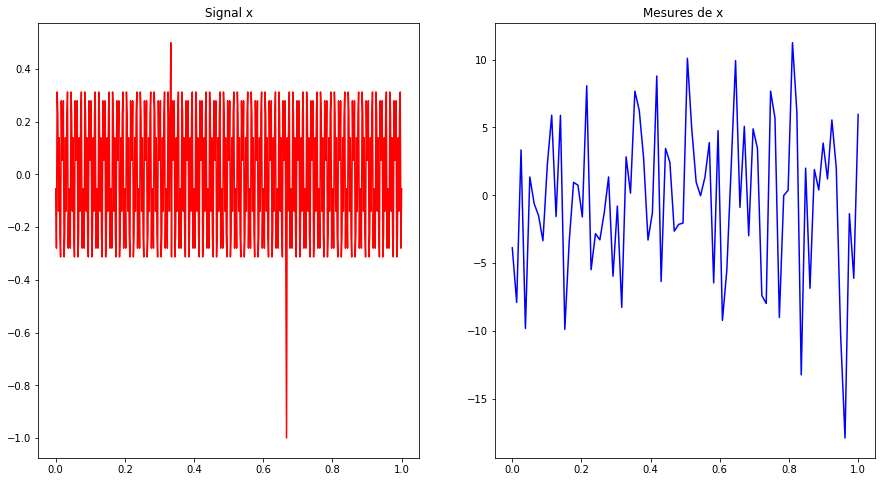

In [ ]:
## Initialisations
n=500            #Taille de l'echantillon
t=np.linspace(0,1,n) #On definit un signal sur [0,1]

## Generation du signal
x=np.zeros(n)
tmp=np.zeros(n)
#On ajoute deux cosinus
tmp[350]=4
x+=fft.idct(tmp,norm='ortho')  
tmp=np.zeros(n)
tmp[150]=-3  
x+=fft.idct(tmp,norm='ortho')
#On ajoute deux diracs
x[int(n/3)]=0.5 #Tester  0.5 valeur initiale 0.2
x[int(2*n/3)]=-1 #Tester -0.3 valeur initiale -1

# Signal de x 
signal=np.copy(x)
plt.figure(0,figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(t,x,'r')
plt.title("Signal x")

## Mesure du signal
p=20*4     #Nombre de mesures   A FAIRE  VARIER
A=np.random.randn(p,n) #La matrice de mesure
y=A.dot(x)        #Les mesures

plt.subplot(1,2,2)
xp = np.linspace(0,1,p)
plt.plot(xp,y,'b')
plt.title("Mesures de x ")
plt.show()

Le code *Generesignal.py* génère un signal discret $x$ qui peut être vu comme une combinaison linéaire de cosinus à différentes fréquences et de diracs. Ce signal n'est pas parcimonieux dans la base canonique des diracs (car il faut à peu près $n$ diracs pour représenter un cosinus) et il n'est pas parcimonieux dans la base des sinus (il faut faire une combinaison linéaire de $n$ cosinus pour représenter un dirac).

Par contre, ce signal est parcimonieux dans un frame qui est l'union de la base canonique et de la base des cosinus. 
Dans ce frame, il suffit en effet de $4$ coefficients non nuls pour reconstruire parfaitement le signal.

> On choisira donc le frame représenté par une matrice $\Psi=(I,C) \in \mathcal{ M}_{2n,n}(\mathbb{R})$ o\`u $C$ est une base de cosinus à différentes fréquences.

### 4.1. Implémentation de l'itération proximale

**Q6** Implémentez l'opérateur linéaire $\Psi$ et son adjoint $\Psi^*$. 

Pour $\Psi$, vous vous servirez de la fonction $dct$ de Python dans la libraire scipy.fftpack qui calcule la transformée en cosinus discret d'un vecteur. Vous ferez attention à préciser *norm='ortho'* dans les options de la $dct$ pour que $idct$ soit bien l'opération inverse de $dct$.

Pour $\Psi^*$, vous utiliserez le fait que la $dct$ est une isométrie quand on précise \textit{norm='ortho'} dans les options de $dct$.

In [ ]:
## Linear function Psi
## (combination of sines and diracs) 
def Psi(alpha) :
    n=np.int(len(alpha)/2)
    y=np.zeros(n)
    x[:]=alpha[:n]+fft.idct(alpha[n:],norm='ortho')
    
    return x

## The transpose of Psi
def PsiT(x) : 
    n=len(x)
    alpha=np.zeros(2*n)
    alpha[:n]=x[:]
    alpha[n:]=fft.dct(x,norm='ortho')
    
    return alpha

**Q7** Implémentez l'algorithme proximal dans la fonction *RestoreX* avec les notations suivantes:
* $A$ est la matrice d'échantillonnage.
* $y$ est le vecteur de mesures.
* $sigma$ est un paramètre du modèle.
* $nit$ est le nombre d'itérations.
* $alpha$ est la solution approximative du problème (4).
* $x$ est donné par Psi $(\alpha)$.
* $CF$ est la fonction coût à chaque itération de l'algorithme. 

In [ ]:
## Prox of the l1−norm 
def prox(alpha,gamma) :
    beta=np.zeros(len(alpha)) 
    beta[:]=np.sign(alpha[:])*np.maximum((np.abs(alpha[:])-gamma),0)
    
    return beta

## Fonction J(alpha)
def J(A,y,sigma,alpha):
    
    return sigma/2*np.linalg.norm(A.dot(Psi(alpha))-y)**2

# Signal reconstruit
def RestoreX(A,y,sigma,nit) :
    it=0
    p,n=np.shape(A)
    alpha=np.zeros(2*n)
    CF=[]
    L=2*sigma*np.linalg.norm(A)**2

    while (it<nit):
        z=A.dot(Psi(alpha))-y
        z=sigma*PsiT(A.T.dot(z))
        alpha=prox(alpha-1/L*z,1/L)
        xtilde1= Psi(alpha)
        CF=CF+[J(A,y,sigma,alpha)+np.linalg.norm(alpha,1)]
        it+=1
        
    return (alpha,xtilde1,CF)

**Q8.** Testez votre algorithme ! Les paramètres $sigma$ et $nit$ sont des à choisir par vous-même (il faut en pratique beaucoup d'itérations pour converger). Vous pourrez observer la façon dont la suite $\alpha^k$ se comporte au fur et à mesure des itérations.

#### Nit optimal

Nous cherchons le $nit$ optimal en nous fixant $sigma = 0.4$.

Tout d'abord, nous faisons varier grossièrement le $nit \in \{1,10,100,1000,10000, 100000\}$.

######################################################################################################
Avec sigma = 0.4 et nit = 1
######################################################################################################


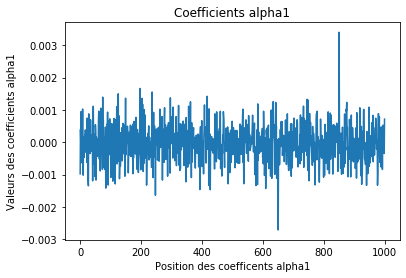

######################################################################################################
Avec sigma = 0.4 et nit = 10
######################################################################################################


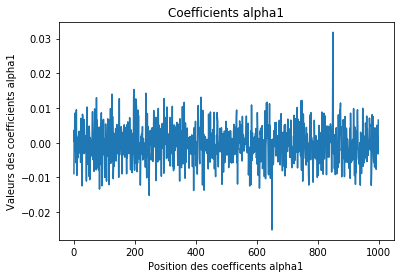

######################################################################################################
Avec sigma = 0.4 et nit = 100
######################################################################################################


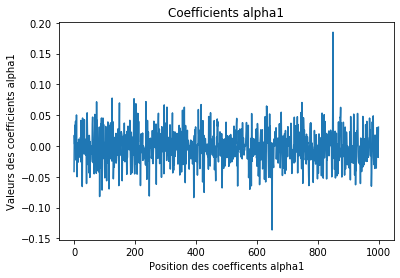

######################################################################################################
Avec sigma = 0.4 et nit = 1000
######################################################################################################


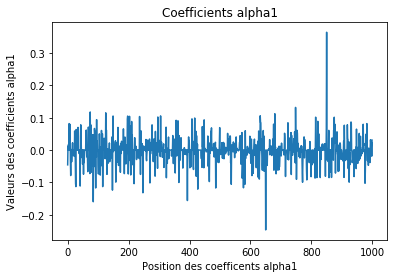

######################################################################################################
Avec sigma = 0.4 et nit = 10000
######################################################################################################


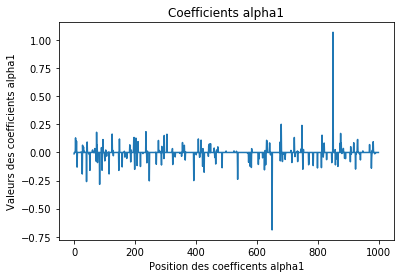

######################################################################################################
Avec sigma = 0.4 et nit = 100000
######################################################################################################


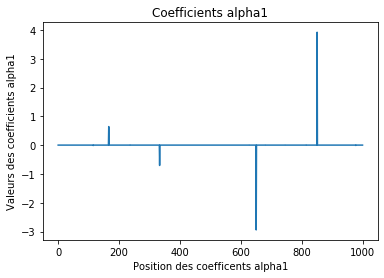

In [ ]:
sigma = 0.4

for k in range(6):
    nit=10**(k)
    (alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
    plt.plot(alpha1)
    print('######################################################################################################')
    print('Avec sigma = 0.4 et nit =', nit)
    print('######################################################################################################')
    plt.title('Coefficients alpha1')
    plt.xlabel('Position des coefficents alpha1')
    plt.ylabel('Valeurs des coefficients alpha1')
    plt.show()

Comme nous constatons un résultat satisfaisant lorsque $nit= 100 000$, nous allons faire varier le $nit$ de 10 000 à 100 000 avec un pas de 10 000 pour affiner encore plus le $nit$.

######################################################################################################
Avec sigma = 0.4 et nit = 10000
######################################################################################################


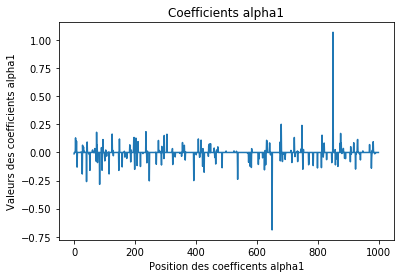

######################################################################################################
Avec sigma = 0.4 et nit = 20000
######################################################################################################


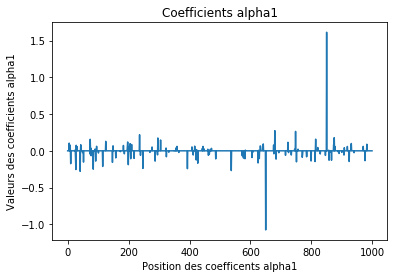

######################################################################################################
Avec sigma = 0.4 et nit = 30000
######################################################################################################


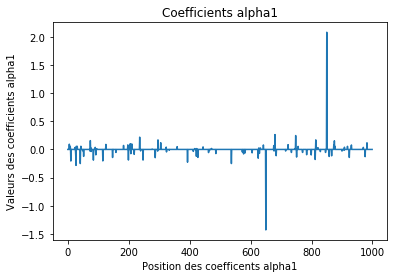

######################################################################################################
Avec sigma = 0.4 et nit = 40000
######################################################################################################


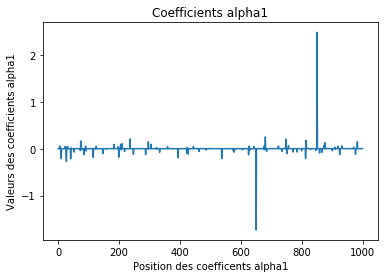

######################################################################################################
Avec sigma = 0.4 et nit = 50000
######################################################################################################


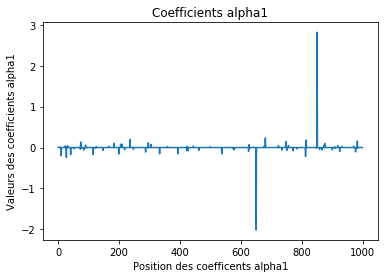

######################################################################################################
Avec sigma = 0.4 et nit = 60000
######################################################################################################


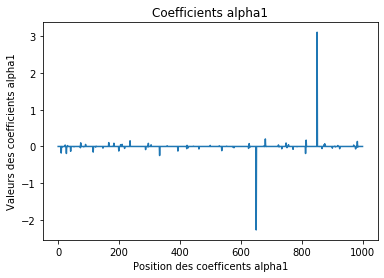

######################################################################################################
Avec sigma = 0.4 et nit = 70000
######################################################################################################


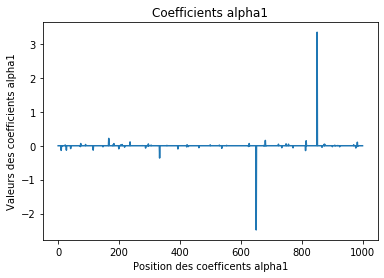

######################################################################################################
Avec sigma = 0.4 et nit = 80000
######################################################################################################


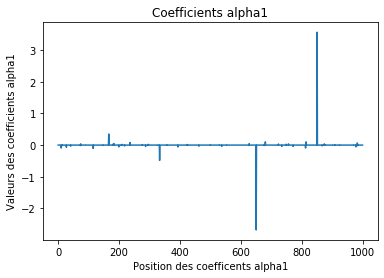

######################################################################################################
Avec sigma = 0.4 et nit = 90000
######################################################################################################


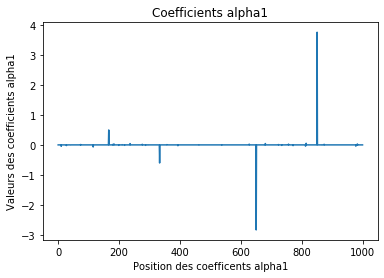

In [ ]:
sigma = 0.4

for k in range(10**4,10**5,10**4):
    nit=k
    (alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
    plt.plot(alpha1)
    print('######################################################################################################')
    print('Avec sigma = 0.4 et nit =', nit)
    print('######################################################################################################')
    plt.title('Coefficients alpha1')
    plt.xlabel('Position des coefficents alpha1')
    plt.ylabel('Valeurs des coefficients alpha1')
    plt.show()

Nous constatons que plus le $nit$ est grand, plus nous distinguons plus facilement les coefficients des deux consinus et des deux diracs.

Nous avons choisir de prendre $$nit = 90 000.$$

#### Sigma optimal

Nous cherchons le $sigma$ optimal en nous fixant $nit = 90 000$ qui est l'optimal des $nit$.

Tout d'abord, nous faisons varier grossièrement le $sigma \in \{0.01,0.10,1,10,100\}$.

######################################################################################################
Avec nit = 90 000 et sigma = 0.01
######################################################################################################


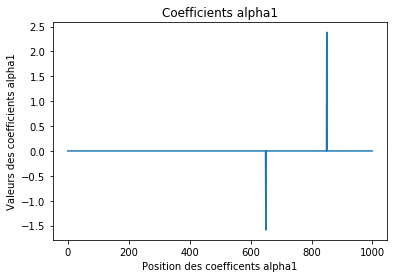

######################################################################################################
Avec nit = 90 000 et sigma = 0.1
######################################################################################################


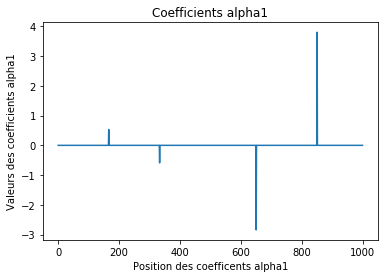

######################################################################################################
Avec nit = 90 000 et sigma = 1
######################################################################################################


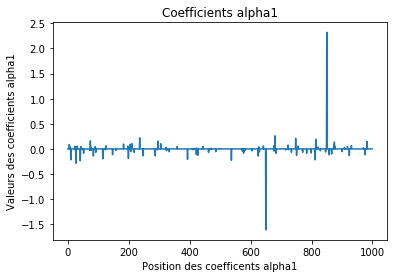

######################################################################################################
Avec nit = 90 000 et sigma = 10
######################################################################################################


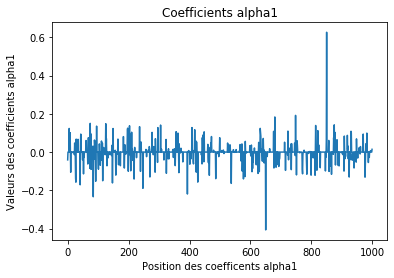

######################################################################################################
Avec nit = 90 000 et sigma = 100
######################################################################################################


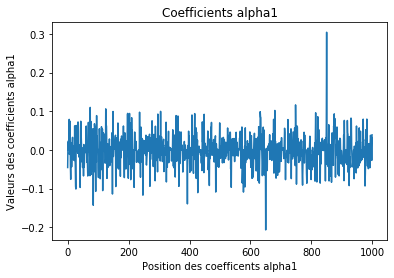

In [ ]:
nit=90000

for k in range(5):
    sigma=10**(k-2)
    (alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
    plt.plot(alpha1)
    print('######################################################################################################')
    print('Avec nit = 90 000 et sigma =', sigma)
    print('######################################################################################################')
    plt.title('Coefficients alpha1')
    plt.xlabel('Position des coefficents alpha1')
    plt.ylabel('Valeurs des coefficients alpha1')
    plt.show()

Comme nous constatons un résultat satisfaisant lorsque $sigma = 0.1 $.

C'est cohérent car si $sigma$ est très petit, nous minimisons seulement la norme de comptage, donc nous obtenons le $sigma$ dont la nombre des coefficents non nuls est petite mais le signal reconstruit n'est pas exact. 

Par exemple, pour $sigma=0.01$, la nombre des coefficents non nuls égale 2, et nous perdons 2 coefficients de $alpha$ donc le signal reconstruit est seulement les fonctions consinus.

Pour le cas que $sigma$ est grand, nous ne minimisons pas la norme de comptage, donc la nombre des coefficents non nuls est grande. Ce n'est pas notre but. 

Maintenant, nous allons faire varier $sigma$ de $0.05$ à $0.3$ pour affiner encore plus le $sigma$.

######################################################################################################
Avec nit = 90 000 et sigma = 0.05
######################################################################################################


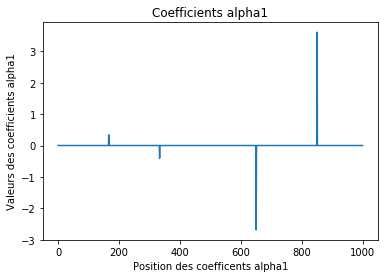

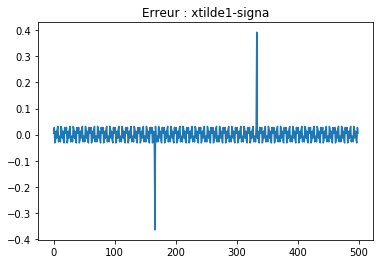

######################################################################################################
Avec nit = 90 000 et sigma = 0.1
######################################################################################################


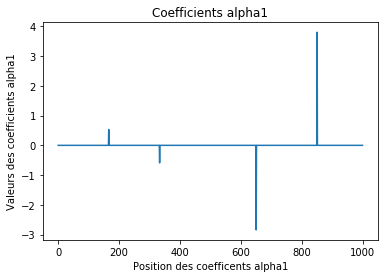

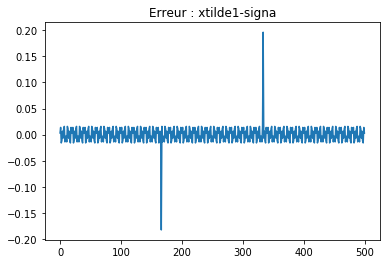

######################################################################################################
Avec nit = 90 000 et sigma = 0.15000000000000002
######################################################################################################


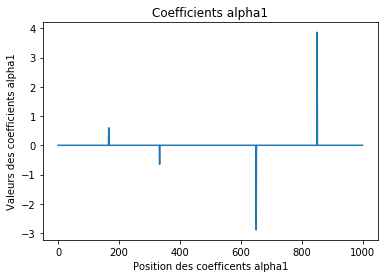

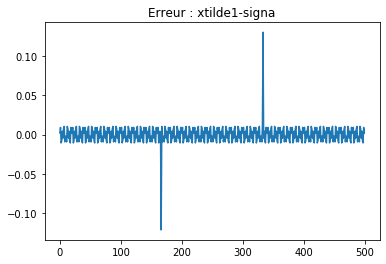

######################################################################################################
Avec nit = 90 000 et sigma = 0.2
######################################################################################################


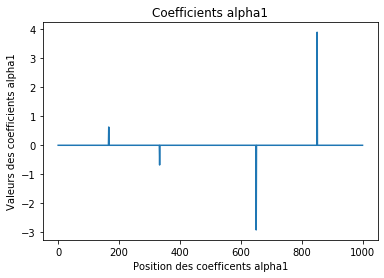

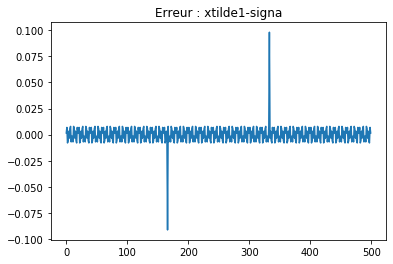

######################################################################################################
Avec nit = 90 000 et sigma = 0.25
######################################################################################################


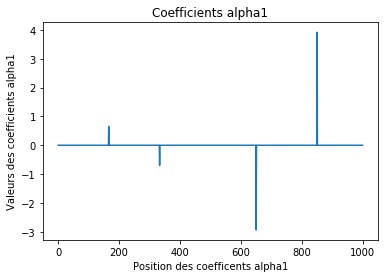

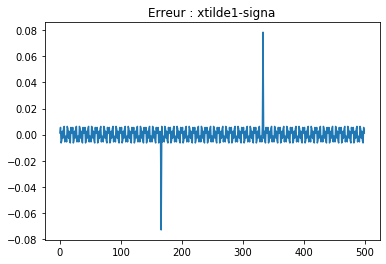

######################################################################################################
Avec nit = 90 000 et sigma = 0.30000000000000004
######################################################################################################


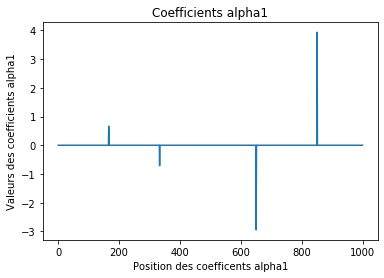

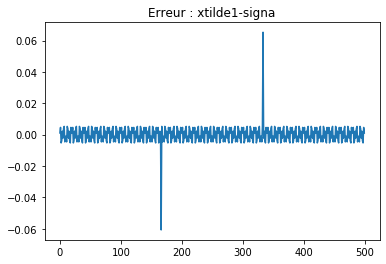

In [ ]:
nit=90000

for i in range(1,7):
    sigma=0.05*i
    (alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
    plt.plot(alpha1)
    print('######################################################################################################')
    print('Avec nit = 90 000 et sigma =', sigma)
    print('######################################################################################################')
    plt.title('Coefficients alpha1')
    plt.xlabel('Position des coefficents alpha1')
    plt.ylabel('Valeurs des coefficients alpha1')
    plt.show()
    plt.plot(xtilde1-signal)
    plt.title('Erreur : xtilde1-signa')
    plt.show()

Comme il n'y a pas de changement significatif, nous avons choisir de prendre $$sigma = 0.2$$ comme $sigma$ optimal. 

**Q9.** Vérifiez que la fonction coût décroit de façon monotone. Quel est le taux de convergence observé ?

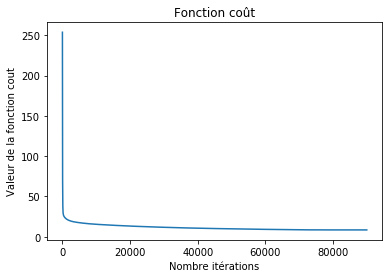

In [ ]:
plt.plot(CF1)
plt.title('Fonction coût')
plt.xlabel('Nombre itérations')
plt.ylabel('Valeur de la fonction cout')
plt.show()

Nous constatons que la fonction coût décroit vite dans 10 000 premières itérations, après elle décroit très peu, puis elle est presque constant. 

Nous en concluons qu'à partir de 20 000 itérations, l'algorithme converge.

Voici le signal reconstruit xtilde1 :

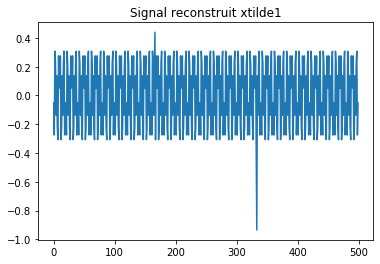

In [ ]:
plt.plot(xtilde1)
plt.title('Signal reconstruit xtilde1')
plt.show()

Voici le graphe de la fonction de coût $CF1(x_{k+1})$ en fonction de $CF1(x_{k})$

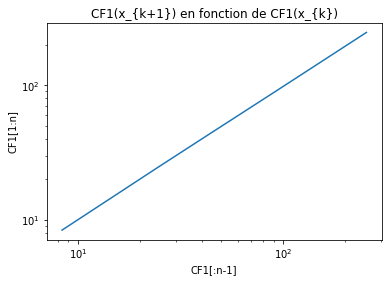

Le coefficient directeur est :  0.9992009892658238
L'ordonnée à l'origine est :  0.001867007886021809


In [ ]:
n=len(CF1)
plt.loglog(CF1[0:n-1],CF1[1:n])

fit=np.polyfit(np.log(CF1[:n-1]), np.log(CF1[1:n]),1)  #approximation par un polynôme d'ordre 1

plt.title('CF1(x_{k+1}) en fonction de CF1(x_{k})')
plt.xlabel('CF1[:n-1]')
plt.ylabel('CF1[1:n]')
plt.show()

print("Le coefficient directeur est : ", fit[0])
print("L'ordonnée à l'origine est : ", fit[1])

Nous constatons que l'ordre de convergence observé de cet algorithme est égal à 1 qui est le coefficient directeur de la droite ci-dessus.

**Q10.** A partir de combien de mesures pouvez-vous reconstruire exactement le signal $x$ ?

Tout d'abord, nous faisons varier grossièrement le nombre de mesure $p \in \{5,10,15,20\}*4$.

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 5 *4
######################################################################################################


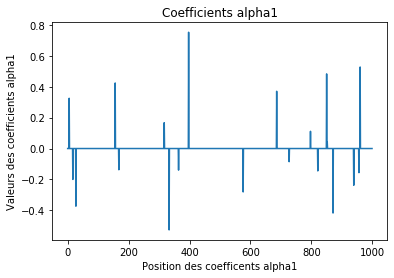

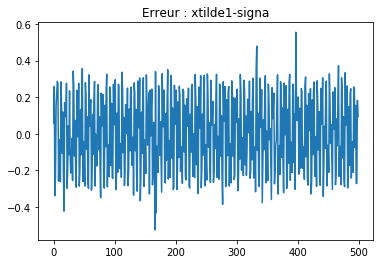

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 10 *4
######################################################################################################


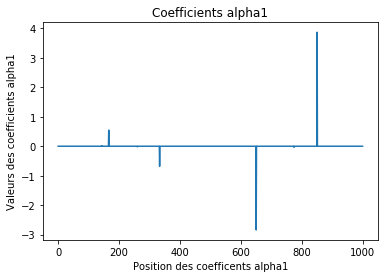

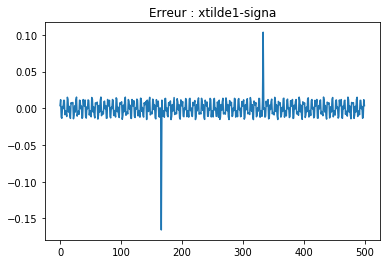

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 15 *4
######################################################################################################


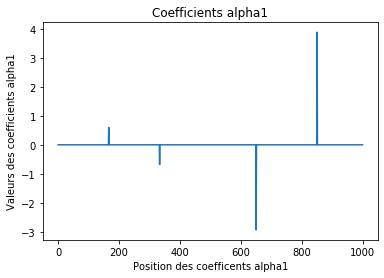

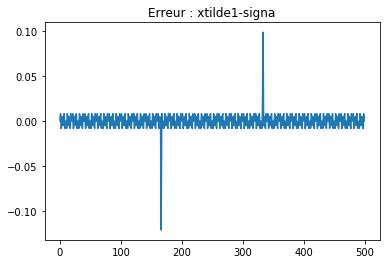

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 20 *4
######################################################################################################


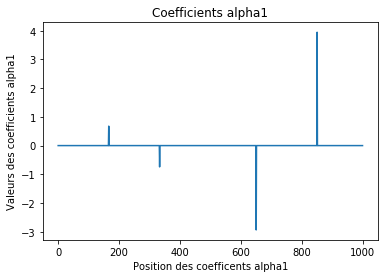

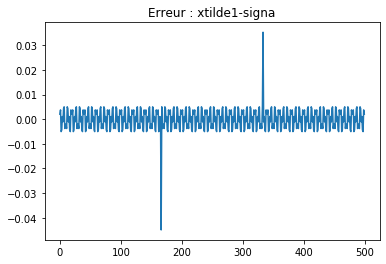

In [ ]:
n=500  #Taille de l'echantillon
nit=90000
sigma=0.2

for i in  range(5,25,5):

    p=4*i
    A=np.random.randn(p,n) 
    y=A.dot(signal)
    (alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
    plt.plot(alpha1)
    print('######################################################################################################')
    print('Avec n = 500, nit = 90 000, sigma = 0.2 et p =',i,'*4')
    print('######################################################################################################') 
    plt.title('Coefficients alpha1')
    plt.xlabel('Position des coefficents alpha1')
    plt.ylabel('Valeurs des coefficients alpha1')
    plt.show()
    plt.plot(xtilde1-signal)
    plt.title('Erreur : xtilde1-signa')
    plt.show()

Nous constatons que les coeffients de alpha1 sont acceptables à partir de $p=15*4$.
Maintenant, nous allons faire varier $p \in \{13,14,15,16,17\}*4$ pour affiner encore plus le $p$.

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 13 *4
######################################################################################################


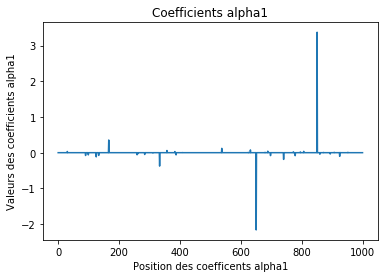

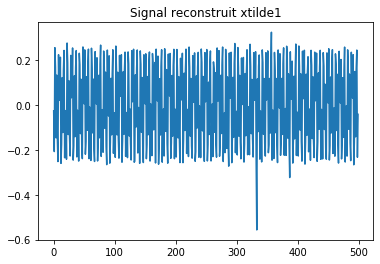

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 14 *4
######################################################################################################


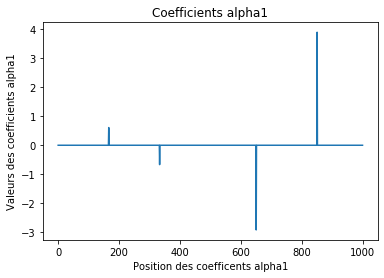

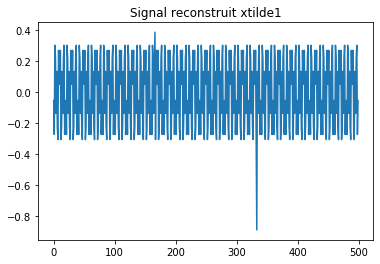

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 15 *4
######################################################################################################


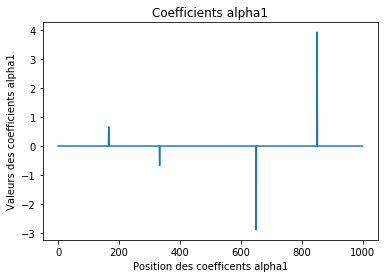

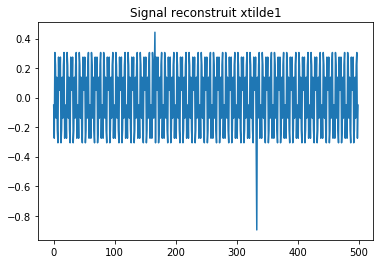

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 16 *4
######################################################################################################


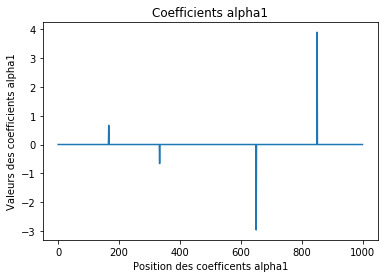

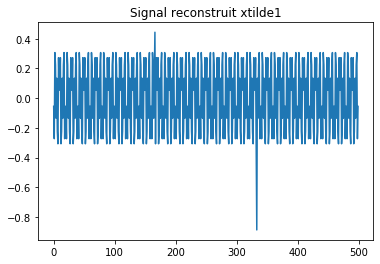

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 17 *4
######################################################################################################


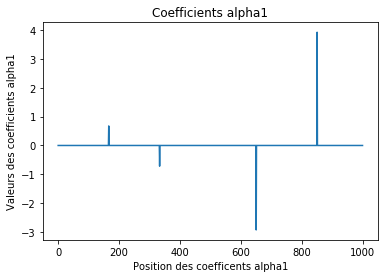

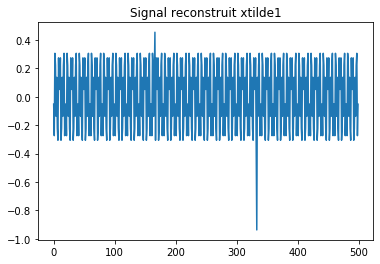

In [ ]:
for i in  range(13,18,1):
    p=4*i
    A=np.random.randn(p,n) 
    y=A.dot(signal)
    (alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
    plt.plot(alpha1)
    print('######################################################################################################')
    print('Avec n = 500, nit = 90 000, sigma = 0.2 et p =',i,'*4')
    print('######################################################################################################') 
    plt.title('Coefficients alpha1')
    plt.xlabel('Position des coefficents alpha1')
    plt.ylabel('Valeurs des coefficients alpha1')
    plt.show()
    plt.plot(xtilde1)
    plt.title('Signal reconstruit xtilde1')
    plt.show()


Comme il n'y a pas de changement significatif, nous avons choisir de prendre la nombre de mesure $$p=15*4=60 $$ car nous observons que le signal reconstruit est presque le même signal initial.

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = 15*4
######################################################################################################


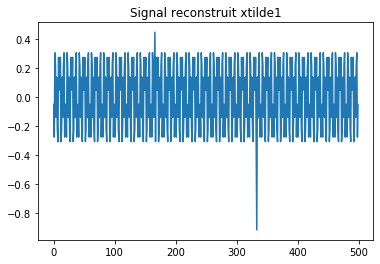

In [ ]:
p=15*4
A=np.random.randn(p,n) 
y=A.dot(signal)
(alpha1,xtilde1,CF1)=RestoreX(A,y,sigma,nit)
print('######################################################################################################')
print('Avec n = 500, nit = 90 000, sigma = 0.2 et p = 15*4')
print('######################################################################################################')
plt.plot(xtilde1)
plt.title('Signal reconstruit xtilde1')
plt.show()


### 4.2. Implémentation de l'itération proximale accelérée

On n'a a aucun moment utilisé la convexité de la fonction $J$ pour définir l'algorithme proximal. Celui-ci est de fait sous-optimal et peut être nettement accéléré. Dans notre cas, l'algorithme accéléré (Nesterov 2007) suit le schéma suivant:

Paramètres en entrée:
* $N$ le nombre d'itérations
* $\alpha^0\in \mathbb{R}^m$ un point initial.

Algorithme
> Poser $B^0=0_\mathbb{R}$, $g^0=0_{\mathbb{R}^m}$, $\alpha=\alpha^0$

> For $k$= $0$ to $N$

>> $t= \frac{2}{L}$ 

>> $a^k = \frac{1}{2}\left(t+\sqrt{t^2+4t B^k}\right)$ 

>> $v^{k} =\mbox{prox}_{B^k\|\cdot\|_1}(\alpha^0-g^k)$ 

>> $w^k = \frac{B^k \alpha^k +a^k v^k}{B^k+a^k}$ 

>>  $\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(w^k-\frac{\nabla J(w^k)}{L}\right)$  

>>	$g^{k+1} = g^k + a^k\nabla J(\alpha^{k+1})$ 

>>	$B^{k+1} = B^k+a^k$
 
**Q11.** En vous aidant de ce que vous avez codé dans la partie précédente, implémentez cet algorithme. 

In [ ]:
def Nesterov(A,y,sigma,nit):
    it=0
    p,n=np.shape(A)
    alpha=np.zeros(2*n)
    CF=[]  
    g=np.zeros(2*n)
    b=0
    L=2*sigma*np.linalg.norm(A)**2
    CF=[]

    for i in range(nit):
        t=2/L
        a=1/2*(t+np.sqrt(t**2+4*t*b))
        v=prox(alpha-g,b)
        w=(b*alpha+a*v)/(b+a)
        z=A.dot(Psi(w))-y
        z=sigma*PsiT(A.T.dot(z))
        alpha=prox(w-z/L,1/L)
        z=A.dot(Psi(alpha))-y
        z=sigma*PsiT(A.T.dot(z))
        g=g+a*z
        b=b+a
        
        CF=CF+[J(A,y,sigma,alpha)+np.linalg.norm(alpha,1)]
    x= Psi(alpha)
    return (alpha,x,CF)

**Q12.** Testez le et comparez la rapidité d'execution de l'algorithme précédent et de celui-ci.

######################################################################################################
Avec n = 500, nit = 90 000, sigma = 0.2 et p = *4
Pour la méthode Nesterov
######################################################################################################


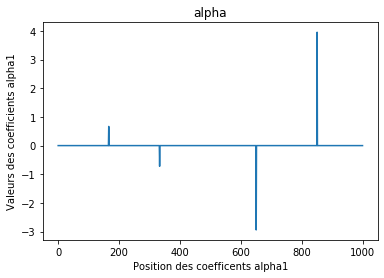

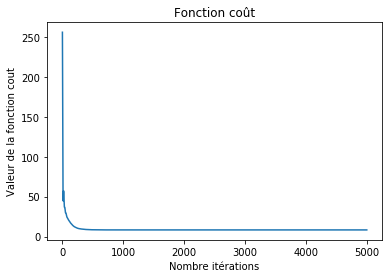

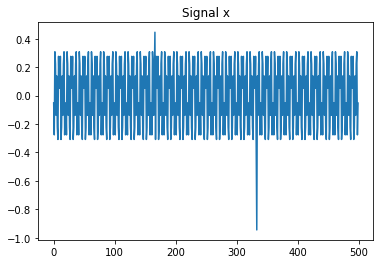

In [ ]:
sigma=0.2
nit=5000

print('######################################################################################################')
print("Avec n = 500, nit = 90 000, sigma = 0.2 et p = *4")
print("Pour la méthode Nesterov")
print('######################################################################################################')

(alpha,x,CF)=Nesterov(A,y,sigma,nit)
plt.plot(alpha)
plt.title('alpha')
plt.xlabel('Position des coefficents alpha1')
plt.ylabel('Valeurs des coefficients alpha1')
plt.show()

plt.plot(CF)
plt.title('Fonction coût')
plt.xlabel('Nombre itérations')
plt.ylabel('Valeur de la fonction cout')
plt.show()

plt.plot(x)
plt.title('Signal x')
plt.show()

Nous savons que l'algorithme d'iteration proximale converge à partir de 20 000 itérations, tandis que avec l'algorithme d'iteration proximale accelérée converge à partir de moins de 1 000 itérations.

Autrement dit, l'algorithme d'iteration proximale accelérée converge 20 fois plus vite que l'algorithme d'iteration proximale normale.

**Q13.** Faites un rapide résumé des points qui vous ont semblé les plus importants dans ce TP.

D'abord, nous remplaçons le problème non convexe (le problème (2)) par le problème convexe (le problème (3)).

Puis, nous ajoutons une contrainte $\frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2$  pour que le signal reconstruit soit exacte. Nous avons alors le problème (4) que nous allons résoudre durant ce TP en utilisant l'algorithme d'itération proximale.

De plus, comme il n'y a pas de critère d'arrête donc il faut faire beaucoup d'itérations pour que l'algorithme converge. C'est pour cela que nous avons essayé de trouver le nombre d'itérations d'optimal pour que le calcul ne soit pas trop longue et pour que nous avons les coefficients $\alpha$ le plus correcte possible. Ici, nous avons choisi $$ nit_{optimal} = 90 000.$$

Ensuite nous avons essayé de trouvé le  $ \sigma_{optimal}$ pour que nous puissons avons les coefficients $\alpha$ le plus correcte comme $nit_{optimal}$. Ici, nous avons choisi $$ \sigma_{optimal} = 0,2.$$

Les deux critères, pour que dans l'algorithme converge, sont $ \sigma_{optimal}$ et  $nit_{optimal}$.

De plus, pour savoir quand l'algorithme converve, nous observons la fonction de coût.

Enfin, nous comparons les deux algorithmes qui sont l'algorithme d'iteration proximale et celle accelérée. Nous constatons que l'algorithme d'iteration proximale accelérée converge 20 fois plus vite que l'algorithme d'iteration proximale normale.